In [88]:
# Summary: <50 mile, with new holiday and NSC month features

In [2]:
# import packages

import pandas as pd
import numpy as np
import os
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

import shap


from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals()) # set the variables to global

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, 
                              GradientBoostingRegressor, ExtraTreesRegressor)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt

from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 120)

In [3]:
# read in dataframe (created by: Batch_One_v2):

df = pd.read_csv('../01_data/04_feature/Features_batch_2_singles_with_rate_sponsorship_v05.csv')


# DATA FILTERING:

# filter out dates prior to trailing window:

print(df.shape)
df['DateCreatedDate'] = pd.to_datetime(df['DateCreatedDate'])
df = df[df['DateCreatedDate'] > '2018-02-01'].reset_index(drop = True)
print(df.shape)
df = df[~df['DaysUntilPickup'].isnull()].reset_index(drop = True)
print(df.shape)
df = df[df['DaysUntilDelivery']>0].reset_index(drop = True)
print(df.shape)
df = df[~df['DaysUntilPickup'].isnull()].reset_index(drop = True)
print(df.shape)

# fix null holiday indicator
df['holiday_indicator'] = np.where(df['holiday_indicator'].isnull(),0,df['holiday_indicator'])


# read in IDs

below_0 = pd.read_csv('../01_data/04_feature/biased dispatchers/IDs that are unbiased w threshold of rounding below0.csv')
below_5 = pd.read_csv('../01_data/04_feature/biased dispatchers/IDs that are unbiased w threshold of rounding below5.csv')
below_10 = pd.read_csv('../01_data/04_feature/biased dispatchers/IDs that are unbiased w threshold of rounding below10.csv')
below_15 = pd.read_csv('../01_data/04_feature/biased dispatchers/IDs that are unbiased w threshold of rounding below15.csv')
below_20 = pd.read_csv('../01_data/04_feature/biased dispatchers/IDs that are unbiased w threshold of rounding below20.csv')
below_25 = pd.read_csv('../01_data/04_feature/biased dispatchers/IDs that are unbiased w threshold of rounding below25.csv')
below_30 = pd.read_csv('../01_data/04_feature/biased dispatchers/IDs that are unbiased w threshold of rounding below30.csv')

print(len(below_0))
print(len(below_5))
print(len(below_10))
print(len(below_15))
print(len(below_20))
print(len(below_25))
print(len(below_30))

(212523, 181)
(202421, 181)
(196772, 181)
(196589, 181)
(196589, 181)
12448
22981
29738
29873
30177
33337
33349


In [4]:
# functions:

def mape(Y_pred, Y_actual):
    return np.mean(np.absolute(Y_pred / Y_actual -1))


def bias(Y_pred, Y_actual):
    return np.mean(Y_pred / Y_actual -1)


def weighted_bias(Y_pred, Y_actual):
    return (sum(Y_pred) / sum(Y_actual)) -1


def run_random_forest(df_forecast, columns, encode, n_jobs, random_seed, splits = 5):

    df_train = df_forecast[(df_forecast['DateCreatedDate'] < '2020-06-01') & (df_forecast['cp_per_mile']<=2)& (df_forecast['cp_per_mile']>=0.6)]
    df_test = df_forecast[(df_forecast['DateCreatedDate'] >= '2020-06-01')]
    df_test_NSC = df_forecast[(df_forecast['DateCreatedDate'] >= '2020-06-01') * (df_forecast['DataSource']=='NSC')]
    df_train = df_train[columns]
    df_test = df_test[columns]
    df_test_NSC = df_test_NSC[columns]
    
    cols_to_encode = encode
    df_train = pd.get_dummies(df_train, columns = cols_to_encode)
    df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    df_test_NSC = pd.get_dummies(df_test_NSC, columns = cols_to_encode)
    
    X_train = df_train.drop(columns = ['CarrierPay'])
    y_train = df_train['CarrierPay']

    features = X_train.columns

    X_test = df_test.drop(columns = ['CarrierPay'])
    y_test = df_test['CarrierPay']
    X_test_NSC = df_test_NSC.drop(columns=['CarrierPay'])
    y_test_NSC = df_test_NSC['CarrierPay']

    del df_train, df_test

    # set to values:
    X_train = X_train.values
    y_train = y_train.values
    X_test= X_test.values
    y_test = y_test.values
    X_test_NSC = X_test_NSC.values
    y_test_NSC = y_test_NSC.values

    # run random forest regression:
    print('RANDOM FOREST REGRESSION:')
    print('----------------------------------------------------------')


    kfold = KFold(n_splits = splits, random_state = random_seed, shuffle = True).split(X_train, y_train)

    model = RandomForestRegressor(n_estimators = 200, n_jobs = n_jobs, random_state = random_seed, min_samples_leaf=20)

    # instantiate lists for post-retraining evaluation:

    fold = []

    
    train_MAPE = [] 
    validation_MAPE = []
    test_MAPE = []
    test_MAPE_NSC = []

    train_BIAS = []
    validation_BIAS = []
    test_BIAS = []
    test_BIAS_NSC = []

    train_wtd_BIAS = []
    validation_wtd_BIAS = []
    test_wtd_BIAS = []


    # train within each fold

    for k, (train, test) in enumerate(kfold): 
  
        model.fit( X = X_train[train], y = y_train[train])
        # R^2 calculations:
        train_acc = model.score( X = X_train[train], y = y_train[train] )
        validation_acc = model.score( X = X_train[test], y = y_train[test] )
        test_acc = model.score( X = X_test, y = y_test )
    
        # generate predictions for the error calc for next code chunk:
        train_pred = model.predict(X = X_train[train])
        validation_pred = model.predict(X = X_train[test])
        test_pred = model.predict(X = X_test)
        test_pred_NSC = model.predict(X = X_test_NSC)
    
    # calculate MAPE:
        train_mape = mape(Y_pred = train_pred, Y_actual = y_train[train])
        validation_mape = mape(Y_pred = validation_pred, Y_actual = y_train[test])
        test_mape = mape(Y_pred = test_pred, Y_actual = y_test)
        test_mape_NSC = mape(Y_pred = test_pred_NSC, Y_actual = y_test_NSC)
   
        train_MAPE.append(train_mape)
        validation_MAPE.append(validation_mape)
        test_MAPE.append(test_mape)
        test_MAPE_NSC.append(test_mape_NSC)
    
        # calculate BIAS:
        train_bias = bias(Y_pred = train_pred, Y_actual = y_train[train])
        validation_bias = bias(Y_pred = validation_pred, Y_actual = y_train[test])
        test_bias = bias(Y_pred = test_pred, Y_actual = y_test)
        test_bias_NSC = bias(Y_pred = test_pred_NSC, Y_actual = y_test_NSC)
	    
        train_BIAS.append(train_bias)
        validation_BIAS.append(validation_bias)
        test_BIAS.append(test_bias)
        test_BIAS_NSC.append(test_bias_NSC)

        # calculate weighted bias:
        #train_wtd_bias = weighted_bias(Y_pred = train_pred, Y_actual = y_train[train])
        #validation_wtd_bias = weighted_bias(Y_pred = validation_pred, Y_actual = y_train[test])
        #test_wtd_bias = weighted_bias(Y_pred = test_pred, Y_actual = y_test)
    
        print('Fold: %2d, Sample size: %s, Train R^2: %3f, Validation R^2: %3f, Test R^2: %3f'%(k+1, np.size(y_train[train]), train_acc, 
                                                                                                validation_acc, test_acc ) )
        print('__________________________, Train MAPE: %3f, Validation MAPE: %3f, Test MAPE: %3f, Test NSC MAPE: %3f'%( train_mape, validation_mape, test_mape, test_mape_NSC ) )
        print('__________________________, Train BIAS: %3f, Validation BIAS: %3f, Test BIAS: %3f, Test NSC BIAS: %3f'%( train_bias, validation_bias, test_bias, test_bias_NSC ) )
        #print('__________________________, Train wtd.BIAS: %3f, Validation wtd.BIAS: %3f, Test wtd.BIAS: %3f'%( train_wtd_bias, validation_wtd_bias, test_wtd_bias ) )


    # MAPE plot:    
    mean_train_MAPE = np.array(train_MAPE).mean()
    mean_validation_MAPE = np.array(validation_MAPE).mean()
    mean_test_MAPE = np.array(test_MAPE).mean()
    mean_test_MAPE_NSC = np.array(test_MAPE_NSC).mean()

    mean_train_BIAS = np.array(train_BIAS).mean()
    mean_validation_BIAS = np.array(validation_BIAS).mean()
    mean_test_BIAS = np.array(test_BIAS).mean()
    mean_test_BIAS_NSC = np.array(test_BIAS_NSC).mean()

    ## Accuracy plot:
    sns.barplot(y = np.array([mean_train_MAPE,mean_validation_MAPE,mean_test_MAPE]),
               x = ['mean_train_MAPE','mean_validation_MAPE','mean_test_MAPE'], color = 'darkblue')

    plt.title('Cross-validation mean results: MAPE')
    plt.tight_layout()
    plt.show()

    # BIAS plot:
    mean_train_BIAS = np.array(train_BIAS).mean()
    mean_validation_BIAS = np.array(validation_BIAS).mean()
    mean_test_BIAS = np.array(test_BIAS).mean()

    mean_train_BIAS = np.array(train_BIAS).mean()
    mean_validation_BIAS = np.array(validation_BIAS).mean()
    mean_test_BIAS = np.array(test_BIAS).mean()

    ## Accuracy plot:
    sns.barplot(y = np.array([mean_train_BIAS,mean_validation_BIAS,mean_test_BIAS]),
               x = ['mean_train_BIAS','mean_validation_BIAS','mean_test_BIAS'], color = 'darkblue')

    plt.title('Cross-validation mean results: BIAS')
    plt.tight_layout()
    plt.show()

    print('Average test BIAS: ', mean_test_BIAS)
    print('Average test MAPE: ', mean_test_MAPE)

    print('Average NSC test BIAS: ', mean_test_BIAS_NSC)
    print('Average NSC test MAPE: ', mean_test_MAPE_NSC)

    feat_labels = features

    # fit the model:
    #model.fit(X_train_scaled, y_train)
    model.fit(X_train, y_train)
        
    # feature importances:
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    for f in range(len(feat_labels)):
            print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

        
    plt.title('Feature Importance')
    plt.bar(range(len(feat_labels)), importances[indices], align = 'center', color = 'darkblue')

    plt.xticks(range(len(feat_labels)), feat_labels[indices], rotation = 90)
    plt.xlim([-1, len(feat_labels)])
    plt.tight_layout()
    plt.show()

RANDOM FOREST REGRESSION:
----------------------------------------------------------
Fold:  1, Sample size: 109154, Train R^2: 0.938327, Validation R^2: 0.927036, Test R^2: 0.835556
__________________________, Train MAPE: 0.094709, Validation MAPE: 0.105368, Test MAPE: 0.183306, Test NSC MAPE: 0.202436
__________________________, Train BIAS: 0.021427, Validation BIAS: 0.024612, Test BIAS: -0.085205, Test NSC BIAS: -0.087298
Fold:  2, Sample size: 109154, Train R^2: 0.937621, Validation R^2: 0.926251, Test R^2: 0.836017
__________________________, Train MAPE: 0.094627, Validation MAPE: 0.104607, Test MAPE: 0.183167, Test NSC MAPE: 0.202475
__________________________, Train BIAS: 0.021475, Validation BIAS: 0.022963, Test BIAS: -0.085399, Test NSC BIAS: -0.085871
Fold:  3, Sample size: 109154, Train R^2: 0.939150, Validation R^2: 0.918538, Test R^2: 0.835273
__________________________, Train MAPE: 0.094440, Validation MAPE: 0.106581, Test MAPE: 0.184052, Test NSC MAPE: 0.202754
__________

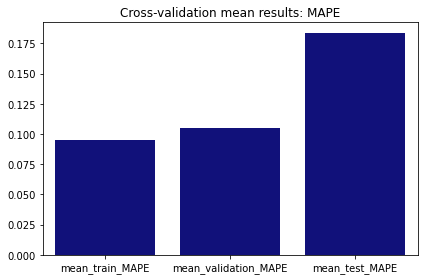

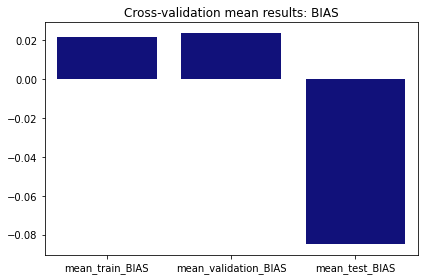

Average test BIAS:  -0.08496440506971956
Average test MAPE:  0.18324877326342764
Average NSC test BIAS:  -0.08666079066984615
Average NSC test MAPE:  0.20253305047837472
 1) adjusted_order_miles           0.914546
 2) baseline_using_mile_rate       0.033147
 3) LoadVSF_category_0-1.66        0.008677
 4) NumVehicleInOp                 0.008310
 5) lane_density_percentile        0.005174
 6) dest_imbalance_index           0.002680
 7) region_record_count            0.002510
 8) origin_imbalance_index         0.002389
 9) NSC_ratio                      0.001984
10) dest_CBSA_record_count         0.001910
11) late_indicator                 0.001725
12) IsEnclosedTruck                0.001646
13) origin_CBSA_record_count       0.001600
14) Origin_Urbanicity              0.001538
15) proportion_cancelled_lane      0.001445
16) LoadVSF_category_2+            0.001415
17) Destination_Urbanicity         0.001399
18) IsDataNSC_ind                  0.000961
19) lane_in_both_NSC_Logistics_ind 0.0

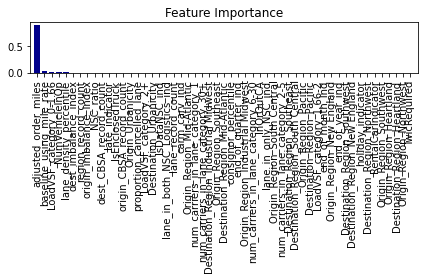

In [35]:
# base model, no IDs filtered out
# using adjusted order miles, VSF category
# added trailing record counts (proxy for lane density)
columns = ['CarrierPay', 'adjusted_order_miles', 'LoadVSF_category', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'carm_carv_ind','IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA',
           'baseline_using_mile_rate', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 'dest_imbalance_index',
           'num_carriers_in_lane_category','consignor_percentile','NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind',
           'end_of_month_ind','end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator','late_indicator',
           'lane_record_count','origin_CBSA_record_count','dest_CBSA_record_count','region_record_count']

encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category','LoadVSF_category']

run_random_forest(df_forecast = df, columns = columns, encode = encode, n_jobs = -1, random_seed = 111, splits = 5)


RANDOM FOREST REGRESSION:
----------------------------------------------------------
Fold:  1, Sample size: 97480, Train R^2: 0.928843, Validation R^2: 0.907106, Test R^2: 0.837125
__________________________, Train MAPE: 0.092798, Validation MAPE: 0.103466, Test MAPE: 0.181064
__________________________, Train BIAS: 0.022792, Validation BIAS: 0.024410, Test BIAS: -0.095581
Fold:  2, Sample size: 97480, Train R^2: 0.927578, Validation R^2: 0.913681, Test R^2: 0.838019
__________________________, Train MAPE: 0.092440, Validation MAPE: 0.104651, Test MAPE: 0.180333
__________________________, Train BIAS: 0.022714, Validation BIAS: 0.025833, Test BIAS: -0.094758
Fold:  3, Sample size: 97480, Train R^2: 0.928653, Validation R^2: 0.910853, Test R^2: 0.837630
__________________________, Train MAPE: 0.092768, Validation MAPE: 0.103665, Test MAPE: 0.181645
__________________________, Train BIAS: 0.022802, Validation BIAS: 0.025519, Test BIAS: -0.094407


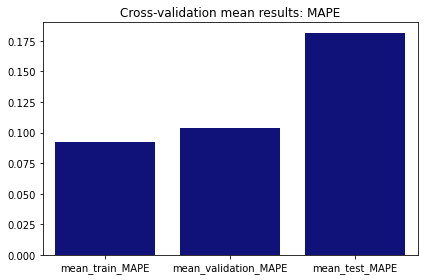

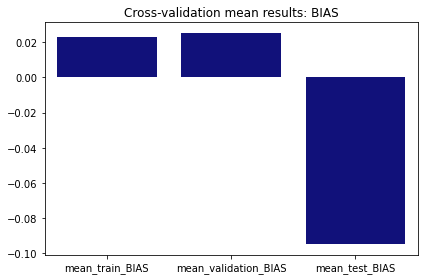

Average test BIAS:  -0.09491529633100056
Average test MAPE:  0.1810136909327947
 1) OrderMiles                     0.859502
 2) baseline_using_mile_rate       0.060570
 3) LoadVSF                        0.022872
 4) lane_density_percentile        0.012300
 5) IsEnclosedTruck                0.008880
 6) NumVehicleInOp                 0.007099
 7) origin_imbalance_index         0.002694
 8) origin_CBSA_record_count       0.002315
 9) dest_imbalance_index           0.001982
10) late_indicator                 0.001939
11) region_record_count            0.001843
12) Origin_Urbanicity              0.001832
13) NSC_ratio                      0.001831
14) dest_CBSA_record_count         0.001726
15) Destination_Urbanicity         0.001722
16) proportion_cancelled_lane      0.001541
17) IsDataNSC_ind                  0.001310
18) num_carriers_in_lane_category_1 0.001148
19) carm_carv_ind                  0.000849
20) lane_record_count              0.000795
21) Origin_Region_Mid-Atlantic     0.00

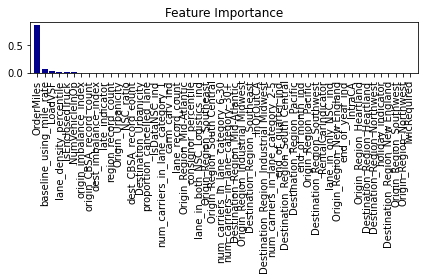

In [33]:
# base model, no IDs filtered out
columns = ['CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'carm_carv_ind','IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 'dest_imbalance_index',
           'num_carriers_in_lane_category','consignor_percentile','NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind',
           'end_of_month_ind','end_of_quarter_ind', 'end_of_year_ind'
           ,'holiday_indicator','late_indicator',
           'lane_record_count','origin_CBSA_record_count','dest_CBSA_record_count','region_record_count']

encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']

run_random_forest_old(df_forecast = df, columns = columns, encode = encode, n_jobs = -1, random_seed = 111, splits = 3)


RANDOM FOREST REGRESSION:
----------------------------------------------------------
Fold:  1, Sample size: 5952, Train R^2: 0.872893, Validation R^2: 0.866576, Test R^2: 0.837091
__________________________, Train MAPE: 0.135318, Validation MAPE: 0.152780, Test MAPE: 0.196147
__________________________, Train BIAS: 0.041771, Validation BIAS: 0.048397, Test BIAS: -0.087386
Fold:  2, Sample size: 5953, Train R^2: 0.889901, Validation R^2: 0.797251, Test R^2: 0.851160
__________________________, Train MAPE: 0.133273, Validation MAPE: 0.155518, Test MAPE: 0.196752
__________________________, Train BIAS: 0.040770, Validation BIAS: 0.049235, Test BIAS: -0.080420
Fold:  3, Sample size: 5953, Train R^2: 0.878913, Validation R^2: 0.842600, Test R^2: 0.842519
__________________________, Train MAPE: 0.135061, Validation MAPE: 0.151547, Test MAPE: 0.193315
__________________________, Train BIAS: 0.041901, Validation BIAS: 0.047614, Test BIAS: -0.085363
Fold:  4, Sample size: 5953, Train R^2: 0.872

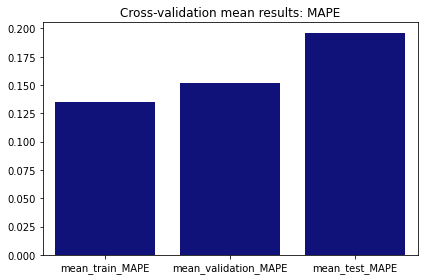

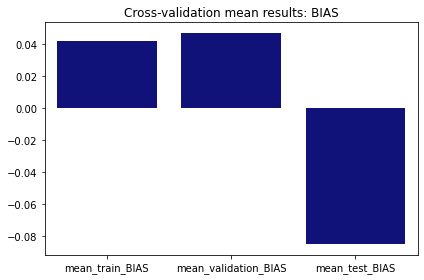

Average test BIAS:  -0.08527517300742335
Average test MAPE:  0.19556662869728533
 1) OrderMiles                     0.837229
 2) trailing_min_cp                0.084249
 3) lane_density_percentile        0.028398
 4) LoadVSF                        0.008534
 5) NSC_ratio                      0.007718
 6) trailing_avg_cp                0.007449
 7) Destination_Urbanicity         0.005395
 8) IsDataNSC_ind                  0.004160
 9) dest_imbalance_index           0.002653
10) origin_imbalance_index         0.002617
11) proportion_cancelled_lane      0.001693
12) NumVehicleInOp                 0.001559
13) Origin_Urbanicity              0.001522
14) consignor_percentile           0.001367
15) lane_in_both_NSC_Logistics_ind 0.000677
16) num_carriers_in_lane_category_1 0.000562
17) num_carriers_in_lane_category_6-30 0.000503
18) Destination_Region_Industrial Midwest 0.000494
19) carm_carv_ind                  0.000487
20) Origin_Region_Mid-Atlantic     0.000457
21) num_carriers_in_lane_ca

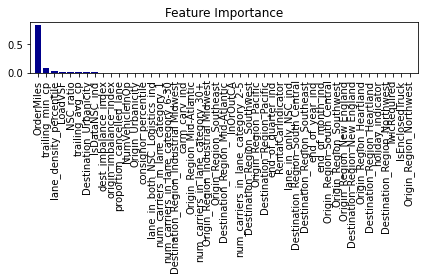

In [65]:
# below 0 filtered out
columns = ['CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'carm_carv_ind','IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA',
           'trailing_avg_cp','trailing_min_cp', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 'dest_imbalance_index',
           'num_carriers_in_lane_category','consignor_percentile','NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind',
           'end_of_month_ind','end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']

ids = below_0['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)
run_random_forest(df_forecast = df_below, columns = columns, encode = encode, n_jobs = -1, random_seed = 111, splits = 5)


RANDOM FOREST REGRESSION:
----------------------------------------------------------
Fold:  1, Sample size: 10738, Train R^2: 0.906780, Validation R^2: 0.824716, Test R^2: 0.874752
__________________________, Train MAPE: 0.115247, Validation MAPE: 0.126141, Test MAPE: 0.134187
__________________________, Train BIAS: 0.033631, Validation BIAS: 0.039379, Test BIAS: -0.006774
Fold:  2, Sample size: 10738, Train R^2: 0.894550, Validation R^2: 0.876675, Test R^2: 0.873623
__________________________, Train MAPE: 0.113612, Validation MAPE: 0.127978, Test MAPE: 0.136486
__________________________, Train BIAS: 0.033032, Validation BIAS: 0.033788, Test BIAS: -0.009142
Fold:  3, Sample size: 10738, Train R^2: 0.893079, Validation R^2: 0.884628, Test R^2: 0.873387
__________________________, Train MAPE: 0.114052, Validation MAPE: 0.125634, Test MAPE: 0.135078
__________________________, Train BIAS: 0.032979, Validation BIAS: 0.033550, Test BIAS: -0.009406
Fold:  4, Sample size: 10739, Train R^2: 0

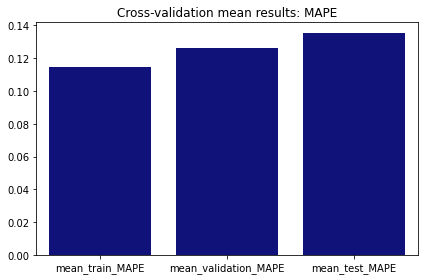

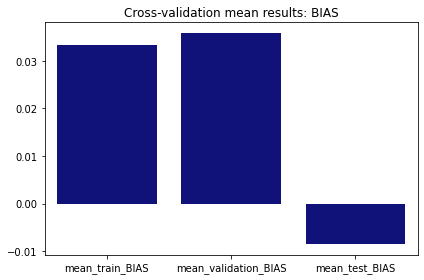

Average test BIAS:  -0.008579223450124334
Average test MAPE:  0.13510075175550693
 1) OrderMiles                     0.831546
 2) trailing_min_cp                0.081712
 3) lane_density_percentile        0.023620
 4) trailing_avg_cp                0.015605
 5) NumVehicleInOp                 0.012129
 6) LoadVSF                        0.006704
 7) Destination_Urbanicity         0.005104
 8) NSC_ratio                      0.003866
 9) IsDataNSC_ind                  0.003171
10) dest_imbalance_index           0.002792
11) Origin_Region_Mid-Atlantic     0.002400
12) origin_imbalance_index         0.002387
13) proportion_cancelled_lane      0.001743
14) Origin_Urbanicity              0.001101
15) consignor_percentile           0.001054
16) Destination_Region_Industrial Midwest 0.000593
17) lane_in_both_NSC_Logistics_ind 0.000581
18) Origin_Region_Industrial Midwest 0.000568
19) carm_carv_ind                  0.000497
20) num_carriers_in_lane_category_1 0.000426
21) num_carriers_in_lane_cat

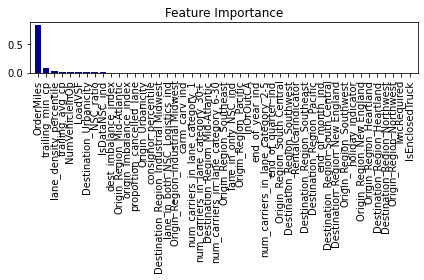

In [55]:
# below 5 filtered out
columns = ['CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'carm_carv_ind','IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA',
           'trailing_avg_cp','trailing_min_cp', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 'dest_imbalance_index',
           'num_carriers_in_lane_category','consignor_percentile','NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind',
           'end_of_month_ind','end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']

ids = below_5['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)
run_random_forest(df_forecast = df_below, columns = columns, encode = encode, n_jobs = -1, random_seed = 111, splits = 5)


RANDOM FOREST REGRESSION:
----------------------------------------------------------
Fold:  1, Sample size: 10334, Train R^2: 0.938710, Validation R^2: 0.922539, Test R^2: 0.863493
__________________________, Train MAPE: 0.089183, Validation MAPE: 0.099912, Test MAPE: 0.177159
__________________________, Train BIAS: 0.020183, Validation BIAS: 0.023405, Test BIAS: -0.110299
Fold:  2, Sample size: 10334, Train R^2: 0.937510, Validation R^2: 0.929453, Test R^2: 0.864653
__________________________, Train MAPE: 0.088988, Validation MAPE: 0.101465, Test MAPE: 0.177179
__________________________, Train BIAS: 0.020114, Validation BIAS: 0.018588, Test BIAS: -0.111689
Fold:  3, Sample size: 10334, Train R^2: 0.939507, Validation R^2: 0.920004, Test R^2: 0.863335
__________________________, Train MAPE: 0.089601, Validation MAPE: 0.102689, Test MAPE: 0.175741
__________________________, Train BIAS: 0.020584, Validation BIAS: 0.033131, Test BIAS: -0.106904
Fold:  4, Sample size: 10335, Train R^2: 0

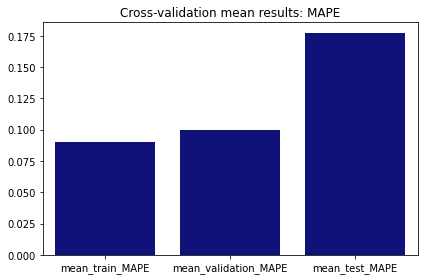

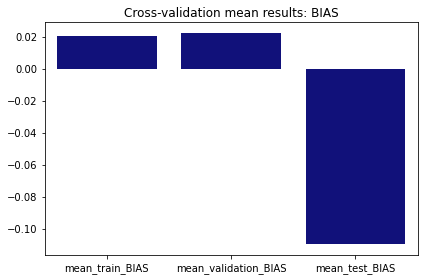

Average test BIAS:  -0.10981401862871878
Average test MAPE:  0.17678418233402277
 1) OrderMiles                     0.957994
 2) trailing_avg_cp                0.006511
 3) lane_density_percentile        0.006300
 4) NumVehicleInOp                 0.006057
 5) LoadVSF                        0.005111
 6) NSC_ratio                      0.002767
 7) origin_imbalance_index         0.002174
 8) Origin_Region_Mid-Atlantic     0.002056
 9) IsDataNSC_ind                  0.001690
10) trailing_min_cp                0.001682
11) dest_imbalance_index           0.001574
12) Destination_Urbanicity         0.001270
13) proportion_cancelled_lane      0.001177
14) Origin_Urbanicity              0.000659
15) num_carriers_in_lane_category_30+ 0.000553
16) Origin_Region_Industrial Midwest 0.000398
17) Destination_Region_Industrial Midwest 0.000291
18) carm_carv_ind                  0.000272
19) num_carriers_in_lane_category_6-30 0.000226
20) consignor_percentile           0.000186
21) lane_in_both_NSC_Lo

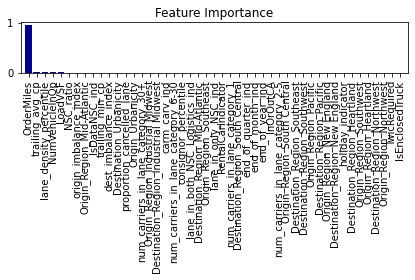

In [69]:
# below 10 filtered out
columns = ['CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'carm_carv_ind','IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA',
           'trailing_avg_cp','trailing_min_cp', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 'dest_imbalance_index',
           'num_carriers_in_lane_category','consignor_percentile','NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind',
           'end_of_month_ind','end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']

ids = below_10['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)
run_random_forest(df_forecast = df_below, columns = columns, encode = encode, n_jobs = -1, random_seed = 111, splits = 5)


RANDOM FOREST REGRESSION:
----------------------------------------------------------
Fold:  1, Sample size: 13726, Train R^2: 0.897570, Validation R^2: 0.893499, Test R^2: 0.877134
__________________________, Train MAPE: 0.116711, Validation MAPE: 0.126203, Test MAPE: 0.131103
__________________________, Train BIAS: 0.034286, Validation BIAS: 0.034184, Test BIAS: 0.002725
Fold:  2, Sample size: 13726, Train R^2: 0.910503, Validation R^2: 0.832290, Test R^2: 0.878833
__________________________, Train MAPE: 0.116674, Validation MAPE: 0.129965, Test MAPE: 0.131620
__________________________, Train BIAS: 0.033919, Validation BIAS: 0.040534, Test BIAS: 0.004570
Fold:  3, Sample size: 13726, Train R^2: 0.897346, Validation R^2: 0.893275, Test R^2: 0.876052
__________________________, Train MAPE: 0.116109, Validation MAPE: 0.127033, Test MAPE: 0.131868
__________________________, Train BIAS: 0.033910, Validation BIAS: 0.035263, Test BIAS: 0.005228
Fold:  4, Sample size: 13727, Train R^2: 0.89

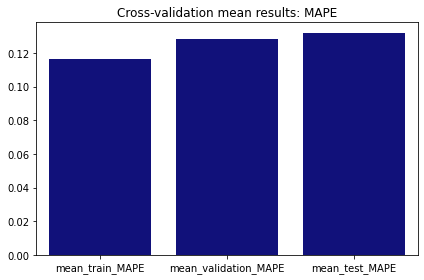

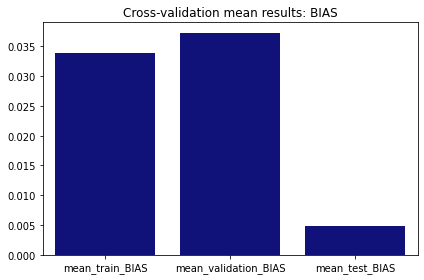

Average test BIAS:  0.00476647297902735
Average test MAPE:  0.13152080817097406
 1) OrderMiles                     0.838468
 2) trailing_min_cp                0.073933
 3) lane_density_percentile        0.021833
 4) trailing_avg_cp                0.019893
 5) NumVehicleInOp                 0.014774
 6) LoadVSF                        0.005832
 7) Destination_Urbanicity         0.004738
 8) NSC_ratio                      0.003753
 9) dest_imbalance_index           0.002573
10) origin_imbalance_index         0.002335
11) IsDataNSC_ind                  0.002208
12) proportion_cancelled_lane      0.001795
13) Origin_Region_Mid-Atlantic     0.001210
14) Origin_Urbanicity              0.001156
15) consignor_percentile           0.000846
16) Destination_Region_Industrial Midwest 0.000541
17) Origin_Region_Industrial Midwest 0.000514
18) lane_in_both_NSC_Logistics_ind 0.000475
19) carm_carv_ind                  0.000420
20) num_carriers_in_lane_category_1 0.000385
21) num_carriers_in_lane_categ

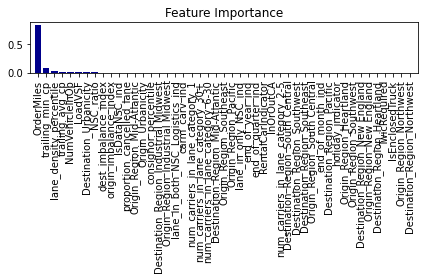

In [56]:
# below 15 filtered out
columns = ['CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'carm_carv_ind','IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA',
           'trailing_avg_cp','trailing_min_cp', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 'dest_imbalance_index',
           'num_carriers_in_lane_category','consignor_percentile','NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind',
           'end_of_month_ind','end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']

ids = below_15['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)
run_random_forest(df_forecast = df_below, columns = columns, encode = encode, n_jobs = -1, random_seed = 111, splits = 5)


RANDOM FOREST REGRESSION:
----------------------------------------------------------
Fold:  1, Sample size: 13867, Train R^2: 0.897629, Validation R^2: 0.888882, Test R^2: 0.875531
__________________________, Train MAPE: 0.117037, Validation MAPE: 0.126684, Test MAPE: 0.131016
__________________________, Train BIAS: 0.034131, Validation BIAS: 0.036010, Test BIAS: 0.005516
Fold:  2, Sample size: 13867, Train R^2: 0.912049, Validation R^2: 0.830172, Test R^2: 0.880870
__________________________, Train MAPE: 0.115636, Validation MAPE: 0.129872, Test MAPE: 0.130733
__________________________, Train BIAS: 0.033469, Validation BIAS: 0.042319, Test BIAS: 0.006004
Fold:  3, Sample size: 13867, Train R^2: 0.898185, Validation R^2: 0.887904, Test R^2: 0.875514
__________________________, Train MAPE: 0.115412, Validation MAPE: 0.127107, Test MAPE: 0.132253
__________________________, Train BIAS: 0.033702, Validation BIAS: 0.036172, Test BIAS: 0.008102
Fold:  4, Sample size: 13867, Train R^2: 0.89

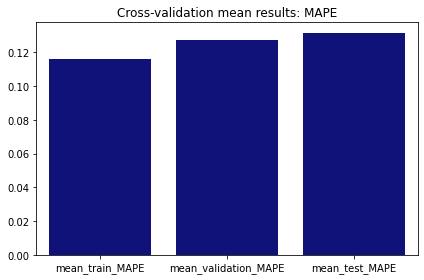

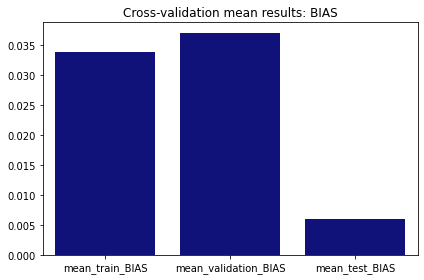

Average test BIAS:  0.005990411463131106
Average test MAPE:  0.1310648630896129
 1) OrderMiles                     0.841186
 2) trailing_min_cp                0.070092
 3) lane_density_percentile        0.021723
 4) trailing_avg_cp                0.019885
 5) NumVehicleInOp                 0.015187
 6) LoadVSF                        0.005779
 7) Destination_Urbanicity         0.005093
 8) NSC_ratio                      0.003892
 9) dest_imbalance_index           0.002717
10) origin_imbalance_index         0.002474
11) IsDataNSC_ind                  0.002327
12) proportion_cancelled_lane      0.001756
13) Origin_Region_Mid-Atlantic     0.001378
14) Origin_Urbanicity              0.001235
15) consignor_percentile           0.000707
16) Origin_Region_Industrial Midwest 0.000550
17) Destination_Region_Industrial Midwest 0.000537
18) num_carriers_in_lane_category_1 0.000441
19) lane_in_both_NSC_Logistics_ind 0.000439
20) carm_carv_ind                  0.000435
21) num_carriers_in_lane_categ

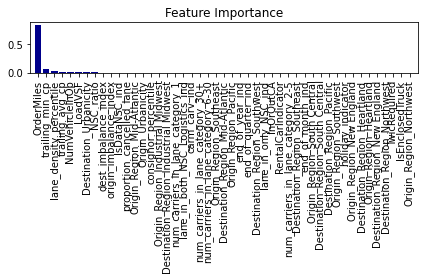

In [57]:
# below 20 filtered out
columns = ['CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'carm_carv_ind','IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA',
           'trailing_avg_cp','trailing_min_cp', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 'dest_imbalance_index',
           'num_carriers_in_lane_category','consignor_percentile','NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind',
           'end_of_month_ind','end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']

ids = below_20['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)
run_random_forest(df_forecast = df_below, columns = columns, encode = encode, n_jobs = -1, random_seed = 111, splits = 5)


RANDOM FOREST REGRESSION:
----------------------------------------------------------
Fold:  1, Sample size: 15308, Train R^2: 0.893434, Validation R^2: 0.892257, Test R^2: 0.867570
__________________________, Train MAPE: 0.117297, Validation MAPE: 0.132229, Test MAPE: 0.133509
__________________________, Train BIAS: 0.034615, Validation BIAS: 0.043331, Test BIAS: 0.003294
Fold:  2, Sample size: 15309, Train R^2: 0.893713, Validation R^2: 0.885632, Test R^2: 0.866384
__________________________, Train MAPE: 0.117558, Validation MAPE: 0.130150, Test MAPE: 0.133176
__________________________, Train BIAS: 0.034494, Validation BIAS: 0.039824, Test BIAS: 0.001727
Fold:  3, Sample size: 15309, Train R^2: 0.909718, Validation R^2: 0.830013, Test R^2: 0.867430
__________________________, Train MAPE: 0.117207, Validation MAPE: 0.127624, Test MAPE: 0.133386
__________________________, Train BIAS: 0.034529, Validation BIAS: 0.034443, Test BIAS: 0.000267
Fold:  4, Sample size: 15309, Train R^2: 0.89

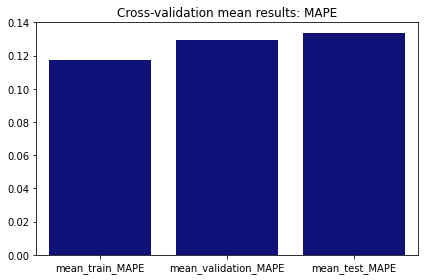

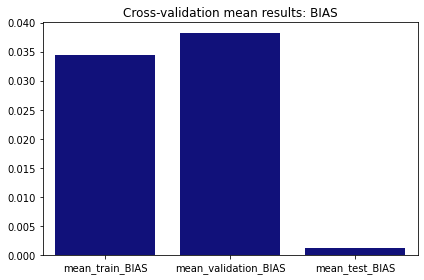

Average test BIAS:  0.0011200656657168906
Average test MAPE:  0.13336138144938656
 1) OrderMiles                     0.831694
 2) trailing_min_cp                0.065716
 3) trailing_avg_cp                0.028898
 4) lane_density_percentile        0.021444
 5) NumVehicleInOp                 0.019007
 6) LoadVSF                        0.005788
 7) Destination_Urbanicity         0.004713
 8) origin_imbalance_index         0.004251
 9) NSC_ratio                      0.003058
10) dest_imbalance_index           0.002616
11) proportion_cancelled_lane      0.002267
12) Origin_Region_Mid-Atlantic     0.001544
13) Origin_Urbanicity              0.001543
14) IsDataNSC_ind                  0.001186
15) consignor_percentile           0.000906
16) carm_carv_ind                  0.000695
17) num_carriers_in_lane_category_30+ 0.000654
18) Origin_Region_Industrial Midwest 0.000588
19) num_carriers_in_lane_category_1 0.000486
20) Destination_Region_Industrial Midwest 0.000386
21) Destination_Region_Mi

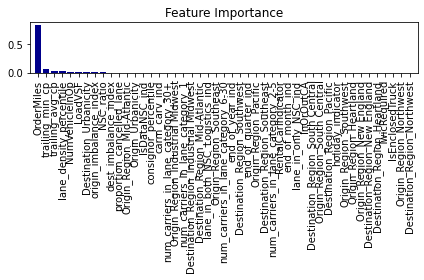

In [58]:
# below 25 filtered out
columns = ['CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'carm_carv_ind','IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA',
           'trailing_avg_cp','trailing_min_cp', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 'dest_imbalance_index',
           'num_carriers_in_lane_category','consignor_percentile','NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind',
           'end_of_month_ind','end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']

ids = below_25['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)
run_random_forest(df_forecast = df_below, columns = columns, encode = encode, n_jobs = -1, random_seed = 111, splits = 5)


RANDOM FOREST REGRESSION:
----------------------------------------------------------
Fold:  1, Sample size: 15318, Train R^2: 0.894803, Validation R^2: 0.888656, Test R^2: 0.868130
__________________________, Train MAPE: 0.117608, Validation MAPE: 0.128963, Test MAPE: 0.133035
__________________________, Train BIAS: 0.034267, Validation BIAS: 0.040079, Test BIAS: 0.001143
Fold:  2, Sample size: 15318, Train R^2: 0.895582, Validation R^2: 0.882863, Test R^2: 0.863339
__________________________, Train MAPE: 0.117286, Validation MAPE: 0.129083, Test MAPE: 0.133234
__________________________, Train BIAS: 0.034648, Validation BIAS: 0.035359, Test BIAS: -0.000863
Fold:  3, Sample size: 15318, Train R^2: 0.910296, Validation R^2: 0.826776, Test R^2: 0.867530
__________________________, Train MAPE: 0.115038, Validation MAPE: 0.134454, Test MAPE: 0.132058
__________________________, Train BIAS: 0.033590, Validation BIAS: 0.037409, Test BIAS: 0.000921
Fold:  4, Sample size: 15319, Train R^2: 0.8

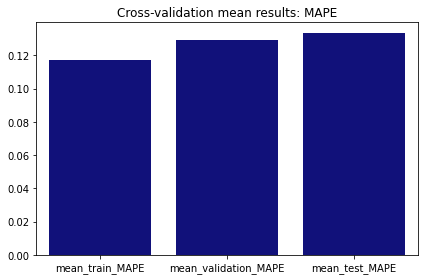

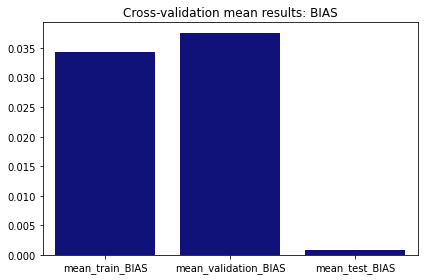

Average test BIAS:  0.000821897163006001
Average test MAPE:  0.133157293119783
 1) OrderMiles                     0.823361
 2) trailing_min_cp                0.074371
 3) trailing_avg_cp                0.028897
 4) lane_density_percentile        0.021773
 5) NumVehicleInOp                 0.019068
 6) LoadVSF                        0.005613
 7) Destination_Urbanicity         0.004554
 8) origin_imbalance_index         0.004205
 9) NSC_ratio                      0.003043
10) dest_imbalance_index           0.002572
11) proportion_cancelled_lane      0.002389
12) Origin_Region_Mid-Atlantic     0.001624
13) Origin_Urbanicity              0.001526
14) IsDataNSC_ind                  0.001264
15) num_carriers_in_lane_category_30+ 0.000776
16) carm_carv_ind                  0.000700
17) consignor_percentile           0.000658
18) Origin_Region_Industrial Midwest 0.000582
19) num_carriers_in_lane_category_1 0.000445
20) Destination_Region_Industrial Midwest 0.000380
21) Destination_Region_Mid-A

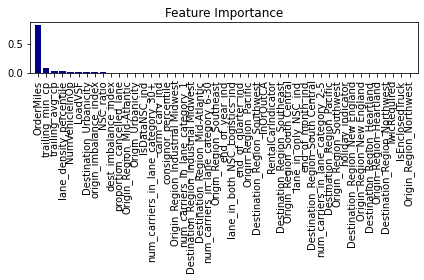

In [59]:
# below 30 filtered out
columns = ['CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'carm_carv_ind','IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA',
           'trailing_avg_cp','trailing_min_cp', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 'dest_imbalance_index',
           'num_carriers_in_lane_category','consignor_percentile','NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind',
           'end_of_month_ind','end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']

ids = below_30['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)
run_random_forest(df_forecast = df_below, columns = columns, encode = encode, n_jobs = -1, random_seed = 111, splits = 5)


In [ ]:
#########################################################################################################################

In [ ]:
############################################################################################################################

In [6]:
# base
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

df_train = df[(df['DateCreatedDate'] < '2020-06-01')&(df['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df[(df['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df.copy()
df_output = df[(df['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('Overall bias: ' + str(bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('# rows overall: ' +str(len(df_NSC_output['rf_predictions'])))
print('# rows outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'])))
print('# rows non-outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'])))

Overall MAPE: 0.1840205918376146
outlier MAPE: 0.2928132386498455
non-outlier MAPE: 0.16232846693914338
Overall bias: -0.0872379696859919
outlier bias: -0.19779289439394598
non-outlier bias: -0.06519446486121165
# rows overall: 4716
# rows outliers: 3932
# rows non-outliers: 784


In [9]:
test = [1,2,3,4,5]
np.mean(test)

3.0

In [10]:
# rolling train/test split
# train may 2018-may 2020, test june 2020
# train june 2018-june 2020, test july 2020
# etc

# base
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

overall_mape = []
outlier_mape = []
nonoutlier_mape = []
overall_bias = []
outlier_bias = []
nonoutlier_bias = []

split = [['2018-05-01','2020-06-01'],['2018-06-01','2020-07-01'],['2018-07-01','2020-08-01'],
        ['2018-08-01','2020-09-01'],['2018-09-01','2020-10-01'],['2018-10-01','2020-11-01']]

for split_start,split_end in split:
    df_train = df[(df['DateCreatedDate'] >= split_start)&(df['DateCreatedDate'] < split_end)&(df['cp_per_mile']<=3)].reset_index(drop = True)
    df_test = df[(df['DateCreatedDate'] >= split_end)].reset_index(drop = True)
    df_train = df_train[columns]
    df_test = df_test[columns]
        
    cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
    df_train = pd.get_dummies(df_train, columns = cols_to_encode)
    df_test = pd.get_dummies(df_test, columns = cols_to_encode)
        
    X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
    y_train = df_train['CarrierPay']

    X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
    y_test = df_test['CarrierPay']

    del df_train, df_test

    # train the model on the entire training set:
    model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

    model.fit(X_train, y_train)

    # predict on the entire sample DF:
    preds = model.predict(X = X_test)

    # recreate the DF:
    df_output = df.copy()
    df_output = df[(df['DateCreatedDate'] >= split_end)].reset_index(drop = True)

    df_output['rf_predictions'] = preds

    # get NSC test MAPE
    df_NSC_output = df_output[df_output['DataSource']=='NSC']

    overall_NSC_mape = mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])
    outlier_NSC_mape = mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])
    nonoutlier_NSC_mape = mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])

    overall_NSC_bias = bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])
    outlier_NSC_bias = bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])
    nonoutlier_NSC_bias = bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])

    overall_mape.append(overall_NSC_mape)
    outlier_mape.append(outlier_NSC_mape)
    nonoutlier_mape.append(nonoutlier_NSC_mape)

    overall_bias.append(overall_NSC_bias)
    outlier_bias.append(outlier_NSC_bias)
    nonoutlier_bias.append(nonoutlier_NSC_bias)

# calculate mean errors across rolling window
print('Overall MAPE: ' + str(np.mean(overall_mape)))
print('outlier MAPE: ' + str(np.mean(outlier_mape)))
print('non-outlier MAPE: ' + str(np.mean(nonoutlier_mape)))

print('Overall bias: ' + str(np.mean(overall_bias)))
print('outlier bias: ' + str(np.mean(outlier_bias)))
print('non-outlier bias: ' + str(np.mean(nonoutlier_bias)))

Overall MAPE: 0.17395357561514815
outlier MAPE: 0.27202268845698785
non-outlier MAPE: 0.15328226807632117
Overall bias: -0.061786604551759335
outlier bias: -0.17271718283513152
non-outlier bias: -0.03865504715998628


Text(0.5, 1.0, 'NSC mape rolling train-test split')

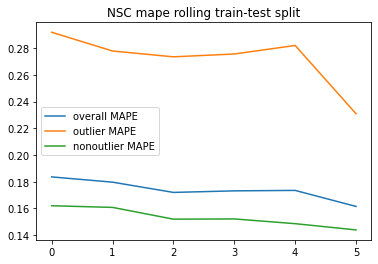

In [15]:
plt.plot(overall_mape,label='overall MAPE')
plt.plot(outlier_mape,label='outlier MAPE')
plt.plot(nonoutlier_mape,label='nonoutlier MAPE')
plt.legend()
plt.title('NSC mape rolling train-test split')

Text(0.5, 1.0, 'NSC bias rolling train-test split')

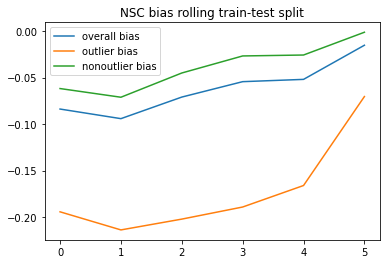

In [16]:
plt.plot(overall_bias,label='overall bias')
plt.plot(outlier_bias,label='outlier bias')
plt.plot(nonoutlier_bias,label='nonoutlier bias')
plt.legend()
plt.title('NSC bias rolling train-test split')

In [5]:
# base, new features for late, loadvsf category, adjusted ordermiles
columns = ['DateCreatedDate','CarrierPay', 'adjusted_order_miles', 'LoadVSF_category', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'carm_carv_ind', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
           'lane_density_percentile', 'origin_imbalance_index', 'dest_imbalance_index',
           'num_carriers_in_lane_category', 'consignor_percentile', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind',
           'end_of_month_ind','end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator','late_indicator',
           'lane_record_count','origin_CBSA_record_count','dest_CBSA_record_count','region_record_count']

df_train = df[(df['DateCreatedDate'] < '2020-06-01')&(df['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df[(df['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category','LoadVSF_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)

    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

df_train_all = df[(df['DateCreatedDate'] < '2020-06-01')].reset_index(drop=True)
df_train_all = df_train_all[columns]
df_train_all = pd.get_dummies(df_train_all,columns=cols_to_encode)
X_train_all = df_train_all.drop(columns = ['CarrierPay', 'DateCreatedDate'])

del df_train, df_test, df_train_all

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)
preds_train = model.predict(X=X_train_all)

# recreate the DF:
df_output = df.copy()
df_output = df[(df['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

df_output_train = df.copy()
df_output_train = df[(df['DateCreatedDate'] < '2020-06-01')].reset_index(drop = True)
df_output_train['rf_predictions'] = preds_train

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('Overall bias: ' + str(bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('# rows overall: ' +str(len(df_NSC_output['rf_predictions'])))
print('# rows outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'])))
print('# rows non-outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'])))

Overall MAPE: 0.18514879495818592
outlier MAPE: 0.30413500714792213
non-outlier MAPE: 0.16142417889593946
Overall bias: -0.08270143939243074
outlier bias: -0.20182781262789123
non-outlier bias: -0.058948876672033725
# rows overall: 4716
# rows outliers: 3932
# rows non-outliers: 784


In [17]:
df_output.to_csv('20210104_test_predictions_v01.csv',index=False)
df_output_train.to_csv('20210104_train_predictions_v01.csv',index=False)

In [199]:
# base, filtered out carrier-consignor relationships

df2 = df[df['agreements_indicator']==0].reset_index()
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

df_train = df2[(df2['DateCreatedDate'] < '2020-06-01')&(df2['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df2[(df2['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df2.copy()
df_output = df2[(df2['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('Overall bias: ' + str(bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('# rows overall: ' +str(len(df_NSC_output['rf_predictions'])))
print('# rows outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'])))
print('# rows non-outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'])))

Overall MAPE: 0.1892176263167446
outlier MAPE: 0.3028543016260926
non-outlier MAPE: 0.16686786220177638
Overall bias: -0.0927118480210588
outlier bias: -0.20134686332612547
non-outlier bias: -0.07134579731529271
# rows overall: 4466
# rows outliers: 3732
# rows non-outliers: 734


In [180]:
# base, round
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

df_train = df[(df['DateCreatedDate'] < '2020-06-01')&(df['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df[(df['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df.copy()
df_output = df[(df['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

# overall mape
print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))


df_NSC_output['mape'] = np.absolute(df_NSC_output['rf_predictions']/df_NSC_output['CarrierPay'] - 1)
df_NSC_output['bias'] = df_NSC_output['rf_predictions']/df_NSC_output['CarrierPay'] - 1
df_NSC_output['rounding_direction'] = np.where(df_NSC_output['bias']<0,1,0)

# round using bias
print('use bias to round up or down')
df_NSC_output['adjusted_prediction'] = np.where(df_NSC_output['rf_predictions']<90,
    5*np.floor(df_NSC_output['rf_predictions']/5 + df_NSC_output['rounding_direction']),
    np.where(df_NSC_output['rf_predictions']<175,10*np.floor(df_NSC_output['rf_predictions']/10+df_NSC_output['rounding_direction']),
    np.where(df_NSC_output['rf_predictions']<400,25*np.floor(df_NSC_output['rf_predictions']/25+df_NSC_output['rounding_direction']),
    np.where(df_NSC_output['rf_predictions']<1000,50*np.floor(df_NSC_output['rf_predictions']/50+df_NSC_output['rounding_direction']),
    100*np.floor(df_NSC_output['rf_predictions']/100 + df_NSC_output['rounding_direction'])))))

print('adjusted overall MAPE: ' + str(mape(Y_pred = df_NSC_output['adjusted_prediction'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('adjusted overall bias: ' + str(bias(Y_pred = df_NSC_output['adjusted_prediction'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

# round without bias
print('round without bias')
df_NSC_output['adjusted_prediction_round_no_bias'] = np.where(df_NSC_output['rf_predictions']<90,5*round(df_NSC_output['rf_predictions']/5,0),
    np.where(df_NSC_output['rf_predictions']<175,10*round(df_NSC_output['rf_predictions']/10,0),
    np.where(df_NSC_output['rf_predictions']<400,25*round(df_NSC_output['rf_predictions']/25,0),
    np.where(df_NSC_output['rf_predictions']<1000,50*round(df_NSC_output['rf_predictions']/50,0),
    100*round(df_NSC_output['rf_predictions']/100,0)))))

print('adjusted overall MAPE: ' + str(mape(Y_pred = df_NSC_output['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('adjusted overall bias: ' + str(bias(Y_pred = df_NSC_output['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

Overall MAPE: 0.18365516658825928
non-outlier MAPE: 0.16191072207730106
outlier MAPE: 0.29271021227332006
Overall MAPE: 0.18365516658825928
non-outlier MAPE: 0.16191072207730106
outlier MAPE: 0.29271021227332006
use bias to round up or down
adjusted overall MAPE: 0.150000900649156
adjusted non-outlier MAPE: 0.12791555610123967
adjusted outlier MAPE: 0.260765664376716
adjusted overall bias: -0.07786124435047226
adjusted non-outlier bias: -0.05695265183747255
adjusted outlier bias: -0.18272423639271052
round without bias
adjusted overall MAPE: 0.18380299553285873
adjusted non-outlier MAPE: 0.16182560889980924
adjusted outlier MAPE: 0.2940263172690202
adjusted overall bias: -0.0887284997259292
adjusted non-outlier bias: -0.0666898425620388
adjusted outlier bias: -0.19925911193054283


In [183]:
print('adjusted overall MAPE: ' + str(mape(Y_pred = df_NSC_output['adjusted_prediction']*1.05, Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted overall bias: ' + str(bias(Y_pred = df_NSC_output['adjusted_prediction']*1.05, Y_actual = df_NSC_output['CarrierPay'])))

adjusted overall MAPE: 0.15246316554014566
adjusted overall bias: -0.03175430656799585


adjusted overall MAPE: 0.18380299553285873
adjusted non-outlier MAPE: 0.16182560889980924
adjusted outlier MAPE: 0.2940263172690202
adjusted overall bias: -0.0887284997259292
adjusted non-outlier bias: -0.0666898425620388
adjusted outlier bias: -0.19925911193054283


In [ ]:
# round without bias
df_NSC_output['adjusted_prediction_round_down'] = np.where(df_NSC_output['rf_predictions']<90,
    5*round(df_NSC_output['rf_predictions']/5 + df_NSC_output['rounding_direction'],0),
    np.where(df_NSC_output['rf_predictions']<175,10*round(df_NSC_output['rf_predictions']/10,0),
    np.where(df_NSC_output['rf_predictions']<400,25*round(df_NSC_output['rf_predictions']/25,0),
    np.where(df_NSC_output['rf_predictions']<1000,50*round(df_NSC_output['rf_predictions']/50,0),
    100*round(df_NSC_output['rf_predictions']/100,0)))))

print('adjusted overall MAPE: ' + str(mape(Y_pred = df_NSC_output['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('adjusted overall bias: ' + str(bias(Y_pred = df_NSC_output['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

In [124]:
# base, plot bias over time for NSC and logistics
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

df_train = df[(df['DateCreatedDate'] < '2020-06-01')&(df['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df[(df['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]

X = df[columns]
X = pd.get_dummies(X, columns = cols_to_encode)
X = X.drop(columns = ['CarrierPay', 'DateCreatedDate'])
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X)

# recreate the DF:
df_output = df.copy()
# df_output = df[(df['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# split by data source
df_NSC_output = df_output[df_output['DataSource']=='NSC']
df_Logistics_output = df_output[df_output['DataSource']=='Logistics']

# calculate mape and bias for each
df_NSC_output['mape'] = np.absolute(df_NSC_output['rf_predictions']/df_NSC_output['CarrierPay'] - 1)
df_NSC_output['bias'] = df_NSC_output['rf_predictions']/df_NSC_output['CarrierPay'] - 1



KeyError: 'rf_predictions'

In [159]:
# plt.figure(figsize=(20,10))
# plt.plot(df_NSC_output['DateCreatedDate'],df_NSC_output['bias']);

In [96]:
# below 0
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

ids = below_0['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)

df_train = df_below[(df_below['DateCreatedDate'] < '2020-06-01')&(df_below['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df_below.copy()
df_output = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('Overall bias: ' + str(bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('# rows overall: ' +str(len(df_NSC_output['rf_predictions'])))
print('# rows outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'])))
print('# rows non-outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'])))

Overall MAPE: 0.1817856105091288
outlier MAPE: 0.3598591347194539
non-outlier MAPE: 0.15917801526155714
Overall bias: -0.09289792493566558
outlier bias: -0.23870750579346764
non-outlier bias: -0.07438644771371852
# rows overall: 648
# rows outliers: 575
# rows non-outliers: 73


In [95]:
# below 5
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

ids = below_5['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)

df_train = df_below[(df_below['DateCreatedDate'] < '2020-06-01')&(df_below['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df_below.copy()
df_output = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('Overall bias: ' + str(bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('# rows overall: ' +str(len(df_NSC_output['rf_predictions'])))
print('# rows outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'])))
print('# rows non-outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'])))

Overall MAPE: 0.15956822762941247
outlier MAPE: 0.29134755655056016
non-outlier MAPE: 0.1378262980467043
Overall bias: -0.07889790503122125
outlier bias: -0.21631556495861262
non-outlier bias: -0.056225721844208314
# rows overall: 925
# rows outliers: 794
# rows non-outliers: 131


In [97]:
# below 10
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

ids = below_10['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)

df_train = df_below[(df_below['DateCreatedDate'] < '2020-06-01')&(df_below['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df_below.copy()
df_output = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('Overall bias: ' + str(bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))
print('non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

print('# rows overall: ' +str(len(df_NSC_output['rf_predictions'])))
print('# rows outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'])))
print('# rows non-outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'])))

Overall MAPE: 0.16019540031214086
outlier MAPE: 0.2889399780941366
non-outlier MAPE: 0.13895094765084384
Overall bias: -0.08092231257421224
outlier bias: -0.21596848910181032
non-outlier bias: -0.05863801793628354
# rows overall: 939
# rows outliers: 806
# rows non-outliers: 133


In [63]:
df_output.to_csv('20201216_below_10_pred.csv',index=False)

In [103]:
%%time

# below 15
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

ids = below_15['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)

df_train = df_below[(df_below['DateCreatedDate'] < '2020-06-01')&(df_below['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df_below.copy()
df_output = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('Overall bias: ' + str(bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('# rows overall: ' +str(len(df_NSC_output['rf_predictions'])))
print('# rows outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'])))
print('# rows non-outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'])))

Overall MAPE: 0.1595423448971744
non-outlier MAPE: 0.13862168189834162
outlier MAPE: 0.28663930507053426
Overall bias: -0.08036171888750725
non-outlier bias: -0.05836775484402091
outlier bias: -0.21397918465545432
# rows overall: 941
# rows outliers: 808
# rows non-outliers: 133
CPU times: user 13.5 s, sys: 140 ms, total: 13.7 s
Wall time: 2.32 s


In [102]:
%%time

# below 20
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

ids = below_20['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)

df_train = df_below[(df_below['DateCreatedDate'] < '2020-06-01')&(df_below['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df_below.copy()
df_output = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('Overall bias: ' + str(bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('# rows overall: ' +str(len(df_NSC_output['rf_predictions'])))
print('# rows outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'])))
print('# rows non-outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'])))

Overall MAPE: 0.16001309458938748
non-outlier MAPE: 0.139140948512049
outlier MAPE: 0.2868153053449476
Overall bias: -0.08127337508986472
non-outlier bias: -0.0592543411389556
outlier bias: -0.2150431452577939
# rows overall: 941
# rows outliers: 808
# rows non-outliers: 133
CPU times: user 13.8 s, sys: 141 ms, total: 13.9 s
Wall time: 2.36 s


In [169]:
%%time

# below 25
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

ids = below_25['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)

df_train = df_below[(df_below['DateCreatedDate'] < '2020-06-01')&(df_below['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df_below.copy()
df_output = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('Overall bias: ' + str(bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('# rows overall: ' +str(len(df_NSC_output['rf_predictions'])))
print('# rows outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'])))
print('# rows non-outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'])))

Overall MAPE: 0.15963401367364946
non-outlier MAPE: 0.13759746632038097
outlier MAPE: 0.27493020341699337
Overall bias: -0.08828432965696223
non-outlier bias: -0.06350065546527375
outlier bias: -0.21795360843889036
# rows overall: 1128
# rows outliers: 947
# rows non-outliers: 181
CPU times: user 15.7 s, sys: 171 ms, total: 15.9 s
Wall time: 2.82 s


In [178]:
# below 25 rounded
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

ids = below_25['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)

df_train = df_below[(df_below['DateCreatedDate'] < '2020-06-01')&(df_below['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df_below.copy()
df_output = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

# overall mape
print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))


df_NSC_output['mape'] = np.absolute(df_NSC_output['rf_predictions']/df_NSC_output['CarrierPay'] - 1)
df_NSC_output['bias'] = df_NSC_output['rf_predictions']/df_NSC_output['CarrierPay'] - 1
df_NSC_output['rounding_direction'] = np.where(df_NSC_output['bias']<0,1,0)
df_NSC_output['rf_predictions_integer'] = round(df_NSC_output['rf_predictions'],0)

# round using bias
print('use bias to round up or down')
df_NSC_output['adjusted_prediction'] = np.where(df_NSC_output['rf_predictions']<90,
    5*np.floor(df_NSC_output['rf_predictions_integer']/5 + df_NSC_output['rounding_direction']),
    np.where(df_NSC_output['rf_predictions_integer']<175,10*np.floor(df_NSC_output['rf_predictions_integer']/10+df_NSC_output['rounding_direction']),
    np.where(df_NSC_output['rf_predictions_integer']<400,25*np.floor(df_NSC_output['rf_predictions_integer']/25+df_NSC_output['rounding_direction']),
    np.where(df_NSC_output['rf_predictions_integer']<1000,50*np.floor(df_NSC_output['rf_predictions_integer']/50+df_NSC_output['rounding_direction']),
    100*np.floor(df_NSC_output['rf_predictions_integer']/100 + df_NSC_output['rounding_direction'])))))

print('adjusted overall MAPE: ' + str(mape(Y_pred = df_NSC_output['adjusted_prediction'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('adjusted overall bias: ' + str(bias(Y_pred = df_NSC_output['adjusted_prediction'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))


# round without bias
print('round without using bias')
df_NSC_output['adjusted_prediction_round_no_bias'] = np.where(df_NSC_output['rf_predictions_integer']<90,5*round(df_NSC_output['rf_predictions_integer']/5,0),
    np.where(df_NSC_output['rf_predictions_integer']<175,10*round(df_NSC_output['rf_predictions_integer']/10,0),
    np.where(df_NSC_output['rf_predictions_integer']<400,25*round(df_NSC_output['rf_predictions_integer']/25,0),
    np.where(df_NSC_output['rf_predictions_integer']<1000,50*round(df_NSC_output['rf_predictions_integer']/50,0),
    100*round(df_NSC_output['rf_predictions_integer']/100,0)))))

print('adjusted overall MAPE: ' + str(mape(Y_pred = df_NSC_output['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('adjusted overall bias: ' + str(bias(Y_pred = df_NSC_output['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction_round_no_bias'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

Overall MAPE: 0.15963401367364946
non-outlier MAPE: 0.13759746632038097
outlier MAPE: 0.2749302034169934
Overall MAPE: 0.15963401367364946
non-outlier MAPE: 0.13759746632038097
outlier MAPE: 0.2749302034169934
use bias to round up or down
adjusted overall MAPE: 0.13155720224746392
adjusted non-outlier MAPE: 0.10909464265534509
adjusted outlier MAPE: 0.24908230685374327
adjusted overall bias: -0.07505139945707344
adjusted non-outlier bias: -0.05164694623060699
adjusted outlier bias: -0.1975045331889171
round without using bias
adjusted overall MAPE: 0.16090609967988428
adjusted non-outlier MAPE: 0.1391230697697161
adjusted outlier MAPE: 0.27487587495573634
adjusted overall bias: -0.08834639178497973
adjusted non-outlier bias: -0.0632919468203455
adjusted outlier bias: -0.21943235521872906


In [179]:
df_NSC_output.to_csv('20201217_25_threshold_round_v02.csv',index=False)

In [167]:
# round down
df_NSC_output['adjusted_prediction_round_down'] = np.where(df_NSC_output['rf_predictions']<90,5*round(df_NSC_output['rf_predictions']/5-1,0),
    np.where(df_NSC_output['rf_predictions']<175,10*round(df_NSC_output['rf_predictions']/10-1,0),
    np.where(df_NSC_output['rf_predictions']<400,25*round(df_NSC_output['rf_predictions']/25-1,0),
    np.where(df_NSC_output['rf_predictions']<1000,50*round(df_NSC_output['rf_predictions']/50-1,0),
    100*round(df_NSC_output['rf_predictions']/100-1,0)))))

print('adjusted overall MAPE: ' + str(mape(Y_pred = df_NSC_output['adjusted_prediction_round_down'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction_round_down'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction_round_down'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('adjusted overall bias: ' + str(bias(Y_pred = df_NSC_output['adjusted_prediction_round_down'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction_round_down'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction_round_down'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

adjusted overall MAPE: 0.19879097666881046
adjusted non-outlier MAPE: 0.17581755274959204
adjusted outlier MAPE: 0.31898894601411354
adjusted overall bias: -0.16758843512542443
adjusted non-outlier bias: -0.14492964576683004
adjusted outlier bias: -0.2861402225430426


In [168]:
# round up
df_NSC_output['adjusted_prediction_round_up'] = np.where(df_NSC_output['rf_predictions']<90,5*round(df_NSC_output['rf_predictions']/5+1,0),
    np.where(df_NSC_output['rf_predictions']<175,10*round(df_NSC_output['rf_predictions']/10+1,0),
    np.where(df_NSC_output['rf_predictions']<400,25*round(df_NSC_output['rf_predictions']/25+1,0),
    np.where(df_NSC_output['rf_predictions']<1000,50*round(df_NSC_output['rf_predictions']/50+1,0),
    100*round(df_NSC_output['rf_predictions']/100+1,0)))))

print('adjusted overall MAPE: ' + str(mape(Y_pred = df_NSC_output['adjusted_prediction_round_up'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction_round_up'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction_round_up'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('adjusted overall bias: ' + str(bias(Y_pred = df_NSC_output['adjusted_prediction_round_up'], Y_actual = df_NSC_output['CarrierPay'])))
print('adjusted non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction_round_up'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('adjusted outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['adjusted_prediction_round_up'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

adjusted overall MAPE: 0.15872650643105027
adjusted non-outlier MAPE: 0.14063977633087757
adjusted outlier MAPE: 0.25335707772863897
adjusted overall bias: -0.00990503004355562
adjusted non-outlier bias: 0.018200023769054493
adjusted outlier bias: -0.15695191380345488


In [113]:
%%time

# below 30
columns = ['DateCreatedDate','CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
           'TwicRequired', 'RentalCarIndicator', 'IsDataNSC_ind',
           'Origin_Region', 'Destination_Region','Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
           'baseline_using_mile_rate','consignor_percentile', 'proportion_cancelled_lane', 
            'lane_density_percentile', 'origin_imbalance_index', 
           'dest_imbalance_index', 'num_carriers_in_lane_category', 'NSC_ratio', 
           'lane_in_both_NSC_Logistics_ind', 'lane_in_only_NSC_ind','end_of_month_ind',
           'end_of_quarter_ind', 'end_of_year_ind',
           'holiday_indicator']

ids = below_30['LoadParentID'].to_list()
df_below = df[df['LoadParentID'].isin(ids)].reset_index(drop=True)

df_train = df_below[(df_below['DateCreatedDate'] < '2020-06-01')&(df_below['cp_per_mile']<=3)].reset_index(drop = True)
df_test = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)
df_train = df_train[columns]
df_test = df_test[columns]
    
cols_to_encode = ['Origin_Region', 'Destination_Region', 'num_carriers_in_lane_category']
df_train = pd.get_dummies(df_train, columns = cols_to_encode)
df_test = pd.get_dummies(df_test, columns = cols_to_encode)
    
X_train = df_train.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_train = df_train['CarrierPay']

X_test = df_test.drop(columns = ['CarrierPay', 'DateCreatedDate'])
y_test = df_test['CarrierPay']

del df_train, df_test

# train the model on the entire training set:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state = 2010 , min_samples_leaf=20)

model.fit(X_train, y_train)

# predict on the entire sample DF:
preds = model.predict(X = X_test)

# recreate the DF:
df_output = df_below.copy()
df_output = df_below[(df_below['DateCreatedDate'] >= '2020-06-01')].reset_index(drop = True)

df_output['rf_predictions'] = preds

# get NSC test MAPE
df_NSC_output = df_output[df_output['DataSource']=='NSC']

print('Overall MAPE: ' + str(mape(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier MAPE: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('Overall bias: ' + str(bias(Y_pred = df_NSC_output['rf_predictions'], Y_actual = df_NSC_output['CarrierPay'])))
print('non-outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('outlier bias: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'],Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['CarrierPay'])))

print('# rows overall: ' +str(len(df_NSC_output['rf_predictions'])))
print('# rows outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['rf_predictions'])))
print('# rows non-outliers: ' +str(len(df_NSC_output[(df_NSC_output['cp_per_mile']>2)|(df_NSC_output['cp_per_mile']<0.6)]['rf_predictions'])))

df_NSC_output['adjusted_prediction'] = df_NSC_output['rf_predictions']*1.06
print('Overall MAPE adjusted: ' + str(mape(Y_pred = df_NSC_output['adjusted_prediction'], Y_actual = df_NSC_output['CarrierPay'])))
print('Overall bias adjusted: ' + str(bias(Y_pred = df_NSC_output['adjusted_prediction'], Y_actual = df_NSC_output['CarrierPay'])))

print('non-outlier MAPE adjusted: ' + str(mape(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))
print('non-outlier bias adjusted: ' + str(bias(Y_pred = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['adjusted_prediction'], Y_actual = df_NSC_output[(df_NSC_output['cp_per_mile']<=2)&(df_NSC_output['cp_per_mile']>=0.6)]['CarrierPay'])))

Overall MAPE: 0.16013982577999408
non-outlier MAPE: 0.1383581194840431
outlier MAPE: 0.2741026758477597
Overall bias: -0.08817477192111625
non-outlier bias: -0.06338908006240991
outlier bias: -0.21785460722606048
# rows overall: 1128
# rows outliers: 947
# rows non-outliers: 181
Overall MAPE adjusted: 0.156406099792638
Overall bias adjusted: -0.033465258236383175
non-outlier MAPE adjusted: 0.13687466593838193
non-outlier bias adjusted: -0.0071924248661544435
CPU times: user 17.3 s, sys: 243 ms, total: 17.5 s
Wall time: 3.7 s


In [98]:
############# Try hypterparameter tuning on the model:

df_model = df[['CarrierPay', 'OrderMiles', 'LoadVSF', 'NumVehicleInOp', 'IsEnclosedTruck',
               'TwicRequired', 'RentalCarIndicator', 'Origin_Region', 'Destination_Region',
               'Origin_Urbanicity', 'Destination_Urbanicity', 'InOrOutCA', 'IntraCA',
               'baseline_cp_per_mile']].reset_index(drop = True)

cols_to_encode = ['Origin_Region', 'Destination_Region']
df_model = pd.get_dummies(df_model, columns = cols_to_encode)


y = df_model['CarrierPay'].values
X = df_model.drop(columns = ['CarrierPay']).values

# break into train and test:

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.10, random_state = 2010)

# setup the grid:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 25, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# instantiate the base model:
rf = RandomForestRegressor(random_state = 2010)

# create the randomized grid search model:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=2010, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.5min


KeyboardInterrupt: 